## Gig Economy Project

By: Janet Taylor & Evan Kessler

Workers in the gig economy (i.e., Uber, GrubHub, TaskRabbit, etc.) depend on the reviews they get to continue working on the platform. Workers on those platforms are often affected by receiving negative reviews that describe elements that were not under their control. The project explores how the analysis of online reviews can detect when unfair reviews are left to workers and identify the type of unfair review that was left.

In [13]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import checkpoint2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, we loaded the .csv files containing the data we cleaned in checkpoint 1. For the purpose of this checkpoint, we only labeling and train on Uber data. The reason why is because Uber has an additional parameter - "Invited" - that can provide additional insight as to if the review was requested by the company. This is set to false for all Lyft reviews.

We preprocess the reviews before doing anything to them. Our first preprocessing step is to remove punctuation (preventing things like "for," being a considered word than "for") and the second step is to correct grammar using TextBlob's .correct() function. Incorrect corrections do not make that much of a difference, while correct ones greatly standardize inputs to the model and therefore result in higher accuracy.

In [14]:
pd.options.display.max_colwidth = 500
if os.path.exists("uber_preprocessed.csv"):
    uber = pd.read_csv("uber_preprocessed.csv")
    uber["Review Body"] = [TextBlob(review) for review in uber["Review Body"]]
else:
    uber = pd.read_csv("uber_cleaned.csv")
    uber["Review Body"] = checkpoint2.preprocess_reviews(uber)
    uber.to_csv("uber_preprocessed.csv", index=False)
lyft = pd.read_csv("lyft_cleaned.csv")



We then convert sentiment to a single number for each word in the dataset and plot the sentiment of the bottom 20 and top 20 words. As expected, words like "stuck", "rude", and "worst" have very negative connotations, while "excellent", "pleasant", and "prompt" have good sentiment values. The get_sentiment_and_counts function also excludes any stopwords and words with length <= 2. Stopwords are words like "the" which are neutral. The sentiment of a review is the sum of the sentiment of all its words.

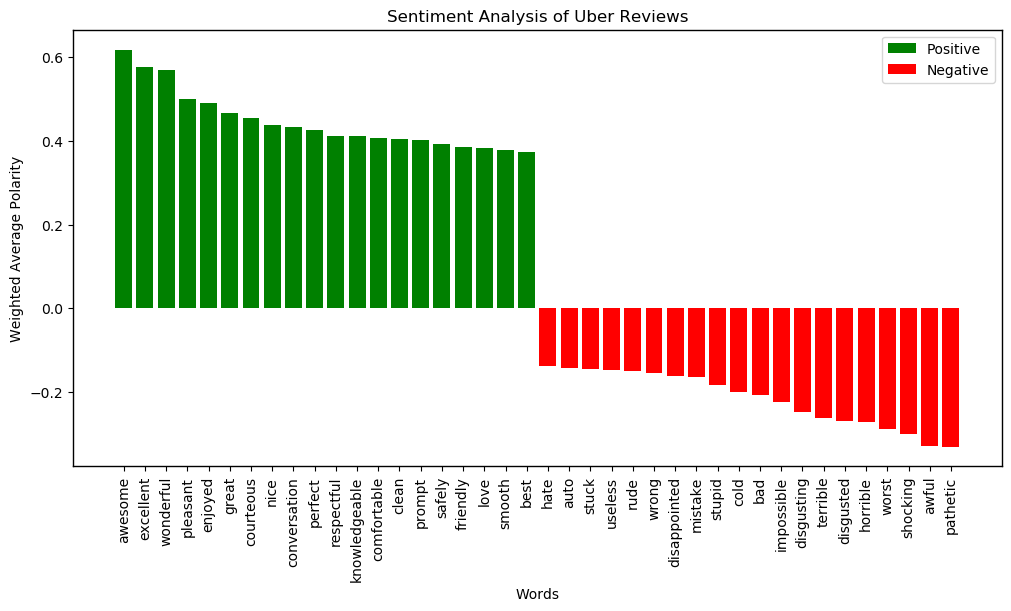

In [15]:
sentiment = checkpoint2.get_weighed_sentiment_counts(checkpoint2.get_sentiment_and_counts(uber))
uber['Sentiment'] = [sum([sentiment[word] if word in sentiment else 0 for word in str(review).split()]) for review in uber['Review Body']]

checkpoint2.plot_sentiment(dict(list(sentiment.items())[:20]), dict(list(sentiment.items())[-20:]))

Sentiment does not depend on unfairness, and it is independant of other variables, so all reviews in the dataset are used for calculating it. The following steps require an "unfair" column to train on. We labeled 650 rows of the Uber dataset for the purposes of this checkpoint.

In [16]:
labeled = uber[uber.Unfair.notnull()].astype({'Invited': 'int32', "Unfair": 'int32'})
print(labeled.shape)
X_labeled = labeled.iloc[:, labeled.columns != 'Unfair']
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

(650, 15)


We initially thought to use a NaiveBayesClassifier to classify reviews. We only used a training set to train the classifier instead of the entire set, because it is not independant and will make the model evaluation unreliable. As seen below, it is around 81% accurate and tends to be very pessimistic. This did not seem good enough for us.

In [17]:
cl_train = []
for x, y in zip(X_train["Review Body"], y_train):
    cl_train.append((x, y))

cl = NaiveBayesClassifier(cl_train, format='json')
labeled['BayesResult'] = [cl.prob_classify(x).max() for x in labeled["Review Body"]]
X_labeled = labeled.iloc[:, labeled.columns.isin(["# Reviews By User", "Invited", "Rating", "Sentiment", "BayesResult"])]
y_labeled = labeled["Unfair"]
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.33, random_state=938)

We tried several different kernels and hyperparameters for the main model, and the SVC model below performed the best.
To see how effective our preprocessing / extra columns were in the end result, we performed SVC several times, excluding certain columns from the dataset each time.

The model with the Bayes classifier and the model including both Bayes and Sentiment were the most accurate. The model with Bayes was more pessimistic and viewed two reviews as fair when we labeled them unfair, while the model without it was more optimistic and inaccurately labeled two unfair instead.

SVC kernel is poly


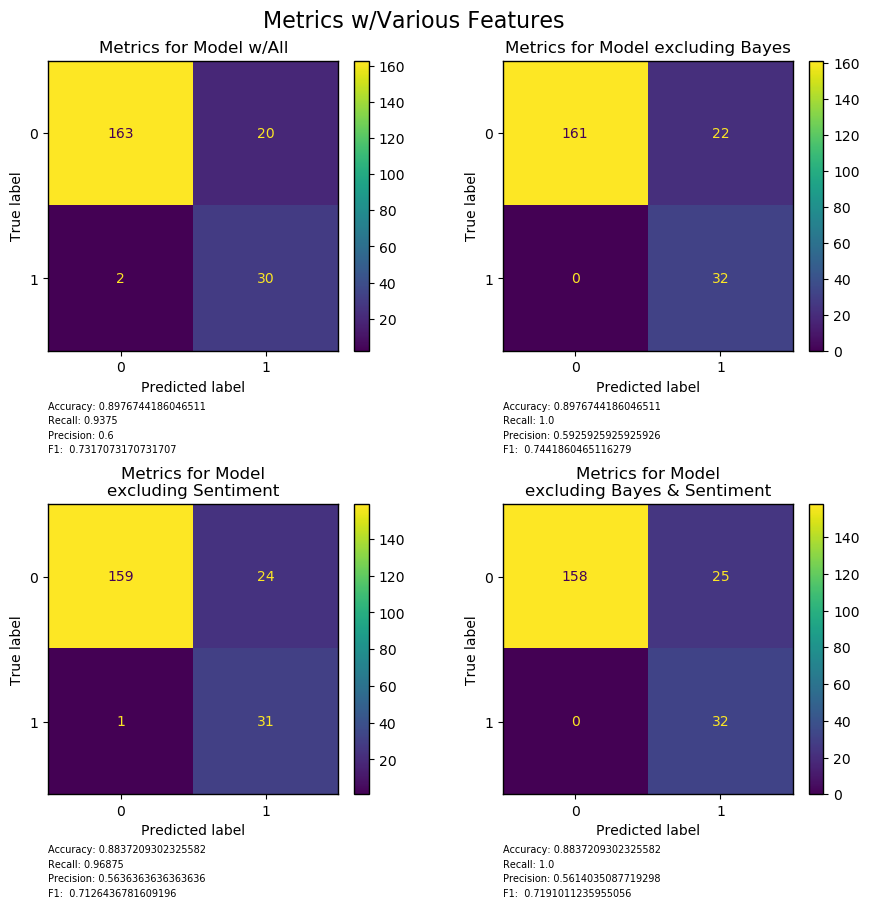

In [18]:

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

kernel = 'poly'
svc = SVC(kernel=kernel, degree=5, class_weight='balanced', coef0=2.4, gamma='auto')
print("SVC kernel is " + kernel)

all_include = checkpoint2.perform_SVC(svc, [], X_train, y_train, X_test, y_test)
bayes_exclude = checkpoint2.perform_SVC(svc, ["BayesResult"], X_train, y_train, X_test, y_test)
sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment"], X_train, y_train, X_test, y_test)
bayes_sent_exclude = checkpoint2.perform_SVC(svc, ["Sentiment", "BayesResult"], X_train, y_train, X_test, y_test)

figure, axis = plt.subplots(2, 2, figsize=(9, 9))
figure.suptitle("Metrics w/Various Features", fontsize=16, ha='center')
checkpoint2.plot_metrics(all_include, "Metrics for Model w/All", ax=axis[0, 0])
checkpoint2.plot_metrics(bayes_exclude, "Metrics for Model excluding Bayes", ax=axis[0, 1])
checkpoint2.plot_metrics(sent_exclude, "Metrics for Model\nexcluding Sentiment", ax=axis[1, 0])
checkpoint2.plot_metrics(bayes_sent_exclude, "Metrics for Model\nexcluding Bayes & Sentiment", ax=axis[1, 1])

Here is the "all" model with some tests run on it:

In [19]:
all_model = SVC(kernel='poly', degree=5, class_weight='balanced', coef0=2.4, gamma='auto', C=8).fit(X_labeled, y_labeled)

In [20]:
reviews = ["the driver was bad and the ride was awful", "the driver was wonderful but the ride was too expensive", "loved the ride it was safe and the driver was talkative"]

custom_cases_array = [
    [3, 1, 1, reviews[0], sum([sentiment[word] if word in sentiment else 0 for word in reviews[0].split()]), cl.classify(reviews[0])],
    [1, 0, 1, reviews[1],sum([sentiment[word] if word in sentiment else 0 for word in reviews[1].split()]), cl.classify(reviews[1])],
    [8, 1, 5, reviews[2],sum([sentiment[word] if word in sentiment else 0 for word in reviews[2].split()]), cl.classify(reviews[2])],
    ]
custom_cases = pd.DataFrame(custom_cases_array, columns=['# Reviews By User', "Invited", "Rating", "Review Body", "Sentiment", "BayesResult"])
custom_cases.drop('Review Body', axis=1, inplace=True)
predictions = all_model.predict(custom_cases)

for i in range(len(reviews)):
    rating = custom_cases_array[i][2]
    if predictions[i]:
        print(f"'{reviews[i]}', which was given {rating} star(s), is an UNFAIR review.")
    else:
        print(f"'{reviews[i]}', which was given {rating} star(s), is a FAIR review.")

'the driver was bad and the ride was awful', which was given 1 star(s), is a FAIR review.
'the driver was wonderful but the ride was too expensive', which was given 1 star(s), is an UNFAIR review.
'loved the ride it was safe and the driver was talkative', which was given 5 star(s), is a FAIR review.


## Checkpoint 3

For this checkpoint, we will be more thoroughly evaluating models and aiming to select the best one. To speed up training as well as improve accuracy, we will start by scaling the data.

To find the best hyperparameters, we used GridSearchCV. To speed things up in the future, I've preloaded each model with the parameters gotten from grid-searching over and over, and commented out `clf`.

In [21]:
scaler = MinMaxScaler()
scaler.fit(X_labeled)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_labeled_scaled = scaler.transform(X_labeled)

We mostly tried supervised learning, with the only exception being the KMeans cluster.

In [22]:
num_clusters = 2
all_model = SVC(kernel='poly', degree=5, shrinking=False, coef0=0.0, C=0.6, class_weight=None)
# clf = GridSearchCV(all_model, refit=True, param_grid={'kernel': ['poly', 'rbf'], 'degree': [2, 3, 4, 5], 'class_weight': [None, 'balanced'], 'coef0': [0], 'gamma': ['auto', 'scale'], 'C': [0.6], 'shrinking': [False, True]}, n_jobs=3).fit(X_labeled_scaled, y_labeled)

clustering = KMeans(num_clusters, n_init=7, random_state=42)


dtclassifier = DecisionTreeClassifier(criterion='entropy', random_state=42, class_weight='balanced', max_features=None, min_samples_split=5, splitter='random')
# clf = GridSearchCV(dtclassifier, refit=True, param_grid={'criterion': ['entropy', 'log_loss', 'gini'], 'max_features': ['sqrt', None, 'log2'], 'splitter': ['best', 'random'], 'min_samples_split': range(2, 8), 'random_state': [42], 'class_weight': [None, 'balanced'], 'ccp_alpha': np.linspace(0, 1, num=10)}, n_jobs=3).fit(X_labeled_scaled, y_labeled)

mlpclassifier = MLPClassifier(random_state=42, max_iter=500000, solver='lbfgs', learning_rate_init=1e-6, hidden_layer_sizes=(116,))
# clf = GridSearchCV(mlpclassifier, refit=True, param_grid={'random_state': [42], 'max_iter': [50000], 'solver': ['adam', 'lbfgs'], 'activation': ['relu'], 'learning_rate_init': np.linspace(1e-6, 1e-5, num=3), 'hidden_layer_sizes': np.linspace(110, 120, num=5, dtype=int)}, n_jobs=3).fit(X_labeled_scaled, y_labeled)

knclassifier = KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', weights='distance')
# clf = GridSearchCV(knclassifier, refit=True, param_grid={'n_neighbors': range(9, 13), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}, n_jobs=3).fit(X_labeled_scaled, y_labeled)


# print(clf.best_params_)
# print(clf.best_score_)


## Model Evaluation / Selection

To select which models we would like to use, we used k-Fold Cross Validation with k=5.

We can completely disregard our KMeans cluster, as its R^2 shows that it has negative correlation with the data.

K-Nearest-Neighbors had the highest accuracy, precision, and r^2. It did have more false negatives than any other model except MLP. The most generous model was the SVM model, and it had the highest recall. For our project, we've decided that higher recall is better than lower recall - we would prefer to label a review as unfair and perhaps have it weighted less (or excluded entirely) from the driver's record than have an unfair review cripple the driver's rating and therefore impact their ability to earn a living.

In [23]:
from tabulate import tabulate
import numpy as np
num_splits = 5
scores = np.array([
    ["All Columns Support Vector Classifier", *checkpoint2.validate_model(all_model, num_splits, X_labeled_scaled, y_labeled)],
    [f"KMeans Cluster (k={num_clusters})", *checkpoint2.validate_model(clustering, num_splits, X_labeled_scaled, y_labeled)],
    ["Decision Tree Classifier", *checkpoint2.validate_model(dtclassifier, num_splits, X_labeled_scaled, y_labeled)],
    ["MLP Classifier", *checkpoint2.validate_model(mlpclassifier, num_splits, X_labeled_scaled, y_labeled)],
    [f"KNN Classifier (k=9)", *checkpoint2.validate_model(knclassifier, num_splits, X_labeled_scaled, y_labeled)]
])
scores = scores[scores[:, 4].argsort()[::-1]]

print(tabulate(scores, headers=['Classifier', 'Average Accuracy', 'Average Recall', 'Average Precision', 'Average F1', 'Average R^2']))

Classifier                               Average Accuracy    Average Recall    Average Precision    Average F1    Average R^2
-------------------------------------  ------------------  ----------------  -------------------  ------------  -------------
All Columns Support Vector Classifier            0.886154          0.845703             0.621329      0.714796       0.886154
Decision Tree Classifier                         0.883077          0.828182             0.620772      0.708541       0.883077
KNN Classifier (k=9)                             0.889231          0.761101             0.658158      0.703541       0.889231
MLP Classifier                                   0.873846          0.658834             0.629408      0.64119        0.873846
KMeans Cluster (k=2)                             0.718462          0.512191             0.477667      0.482827     -23.9608


The three models we chose to compare, then, were the Decision Tree Model on its own, the KNN model on its own, and then a new model formed from the consensus of DT+KNN+SVC. We called this the "chained_model."

In [24]:
chaining_dataset = pd.DataFrame(X_labeled_scaled.copy(), columns=X_labeled.columns)
chaining_dataset['DT'] = dtclassifier.fit(X_train_scaled, y_train).predict(X_labeled_scaled)
chaining_dataset['KNN'] = knclassifier.fit(X_train_scaled, y_train).predict(X_labeled_scaled)

In [25]:
chained_model = SVC(kernel='poly', degree=8, gamma='scale', shrinking=False, coef0=0.0, C=0.001, class_weight='balanced')
# clf = GridSearchCV(chained_model, refit=True, param_grid={'kernel': ['poly', 'rbf'], 'degree': [6, 7, 8], 'class_weight': [None, 'balanced'], 'coef0': np.linspace(0, .01, num=5), 'gamma': ['auto', 'scale'], 'shrinking': [False, True], 'C': np.linspace(0.001, 0.01, num=5)}, n_jobs=3).fit(chaining_dataset, y_labeled)

# print(clf.best_score_)
# print(clf.best_params_)
print(checkpoint2.validate_model(chained_model, num_splits, chaining_dataset, y_labeled))
chained_model.fit(chaining_dataset, y_labeled)

[0.96307692 0.95375214 0.84754209 0.89736588 0.96307692]


SVC(C=0.001, class_weight='balanced', degree=8, kernel='poly', shrinking=False)

## Experiment - extrapolating to Lyft dataset w/o labeling any reviews

To test the effects of our three models, we try running the model on the Lyft set. The Lyft set is fundamentally different in a few ways (namely, it has no 1 values in the Invited column, and is a little less cleaned). It also contains many more negative reviews.

We select 20 random samples from the Lyft dataset, preprocess it, and run it on all three models.

In [26]:
import textwrap

len_sample = 20
random = True

if random:
    sample = lyft[~lyft["Review Body"].str.contains('driving') & lyft["# Reviews By User"].astype(str).str.isdigit()].sample(len_sample)
else:
    sample = lyft.iloc[0:len_sample]
sample = sample.iloc[:, lyft.columns.isin(["# Reviews By User", "Invited", "Rating", "Review Body"])]
original = sample.copy()
sample["Review Body"] = checkpoint2.preprocess_reviews(sample)
sample['Sentiment'] = [sum([sentiment[word] if word in sentiment else 0 for word in str(review).split()]) for review in sample['Review Body']]
sample["BayesResult"] = [cl.classify(x) for x in sample["Review Body"]]
sample.drop("Review Body", axis=1, inplace=True)

sample_scaled = scaler.transform(sample)
sample = pd.DataFrame(sample_scaled, columns=sample.columns)


dt_predictions = dtclassifier.predict(sample)
knn_predictions = knclassifier.predict(sample)
sample['DT'] = dtclassifier.predict(sample_scaled)
sample['KNN'] = knclassifier.predict(sample_scaled)
chained_predictions = chained_model.predict(sample)

table = []
for i in range(len_sample):
    row = original.iloc[i, :]
    table.append(['\n'.join(textwrap.wrap(str(row["Review Body"]))), row["Rating"], row["Invited"], dt_predictions[i], knn_predictions[i], chained_predictions[i]])

sample_results = pd.DataFrame(table, columns=['Review Body', 'Rating', 'Invited', 'DT Prediction', 'KNN Prediction', 'Combined Model Prediction'])
print(tabulate(sample_results, headers=sample_results.columns, tablefmt='fancy_grid'))

╒════╤════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤═════════════════╤══════════════════╤═════════════════════════════╕
│    │ Review Body                                                            │   Rating │ Invited   │   DT Prediction │   KNN Prediction │   Combined Model Prediction │
╞════╪════════════════════════════════════════════════════════════════════════╪══════════╪═══════════╪═════════════════╪══════════════════╪═════════════════════════════╡
│  0 │ i love being a driver for lyft. i have met so many wonderful people,   │        5 │ False     │               0 │                0 │                           0 │
│    │ some really funny ones, and some quiet ones. this is the best job i    │          │           │                 │                  │                             │
│    │ ever had. i get to make my own schedule and do things at my own pace.  │          │           │                 │                  │           

/home/janett/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/janett/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Most of the time, all three models agree - so let's zone in on the cases where they do not.

In [27]:
print(tabulate(sample_results.loc[(sample_results["DT Prediction"] != sample_results["Combined Model Prediction"]) | (sample_results["KNN Prediction"] != sample_results["Combined Model Prediction"]), :], headers=sample_results.columns, tablefmt='fancy_grid'))

╒════╤════════════════════════════════════════════════════════════════════════╤══════════╤═══════════╤═════════════════╤══════════════════╤═════════════════════════════╕
│    │ Review Body                                                            │   Rating │ Invited   │   DT Prediction │   KNN Prediction │   Combined Model Prediction │
╞════╪════════════════════════════════════════════════════════════════════════╪══════════╪═══════════╪═════════════════╪══════════════════╪═════════════════════════════╡
│  5 │ driver didn't show. no customer service on weekends. are they kidding? │        1 │ False     │               1 │                0 │                           0 │
├────┼────────────────────────────────────────────────────────────────────────┼──────────┼───────────┼─────────────────┼──────────────────┼─────────────────────────────┤
│  7 │ the app kept telling me a driver is on the way. no one ever showed up. │        1 │ False     │               1 │                0 │           

Overall, I think it is reasonable what the outcome of the combined result was!

Unfortunately, due to the nature of the data, it's quite difficult to get a great visualization of the model itself. It is mostly discrete variables - the only continous one is the Sentiment column.

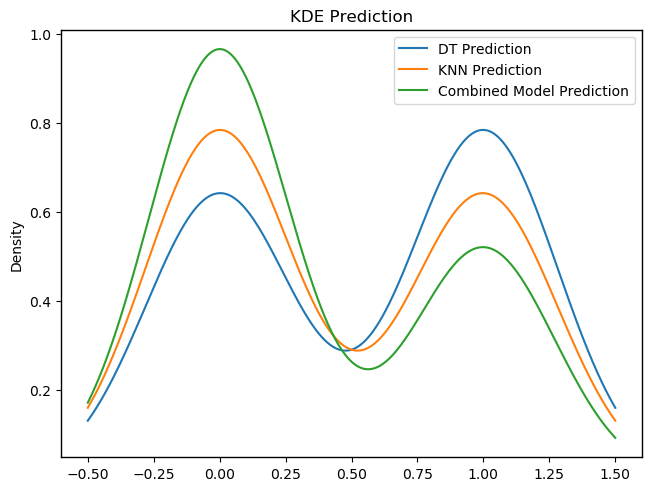

In [28]:
sample_results.iloc[:, 3:].plot.kde(title='KDE Prediction')